# Model Train

We are generating dengue case forecasts

Features were generated by script `dataprep.py`

```bash
# running this pushes the data to the database
./scripts/dataprep.py
```

In [1]:
import pandas as pd

from plotnine import ggplot, aes, geom_line, geom_ribbon, xlab, ylab
from dengue.models import INLAForecastModel_V1

# First model

In [2]:
config_file = "/home/wesley/github/etheleon/national_analysis/dengue/models/INLA/config.yaml"
! cat {config_file}

train:
  start_time: 2020-01-01
  end_time: 2022-12-31
test:
  start_time: 2023-01-01
  end_time: 2023-12-31
dataset: national_analysis.inla_model
target: cases
model:
  horizon: 0
  inla:
    family: 'nbinomial'
    offset: 'log(population/100000)'
    control:
      inla:
        strategy: 'adaptive'
      predictor:  # to compute predictions
        link: 1
        compute: true
      compute:
        return.marginals.predictor: true
        dic: true
        waic: true
        cpo: true
        config: true
      fixed: 
        correlation.matrix: true
        prec.intercept: 1
        prec: 1
    num.threads: 4
    verbose: false
  hyperparameters: 
    - prec:
        prior: 'pc.prec'
        param: [0.5,x: 0.01]
features:
  - name: days_since_switch
    variable_type: group
    bins: 18
    model: 'rw2'
    scale_model: 'TRUE'
  - name: max_t_scale_12_wk_avg_0
    variable_type: group
    bins: 25
    model: 'rw2'
    scale_model: 'TRUE'
  - name: nino34_12_wk_avg_4
    variabl

## Fit model

In [4]:
model = INLAForecastModel_V1(config_file)
model.generateDataset()
model.fit()

{"message": "Data retrieved successfully", "taskName": "Task-2", "query": "SELECT * FROM national_analysis.inla_model_ds", "row_count": 209}


In [6]:
# with observed cases
input_data = model.get_data()
input_data

,year,eweek,max_t_scale_12_wk_avg_0,days_since_switch,nino34_12_wk_avg_4,days_no_rain_12_wk_total_0,cases,population,date,yearmonth,cases_actual
1,2020.0,1.0,-0.242666,0.0,0.000000,1.0,NaN,5685807.0,2019-12-30,202001,NaN
2,2020.0,2.0,-0.268050,0.0,0.000000,2.0,343.0,5685807.0,2020-01-06,202002,343.0
3,2020.0,3.0,-0.010742,7.0,0.000000,3.0,404.0,5685807.0,2020-01-13,202003,404.0
4,2020.0,4.0,0.020934,14.0,0.000000,6.0,309.0,5685807.0,2020-01-20,202004,309.0
5,2020.0,5.0,0.016590,21.0,0.600000,6.0,370.0,5685807.0,2020-01-27,202005,370.0
...,...,...,...,...,...,...,...,...,...,...,...
205,2023.0,48.0,0.852986,91.0,1.566667,9.0,NaN,5917648.0,2023-11-27,202348,144.0
206,2023.0,49.0,0.782257,98.0,1.608333,7.0,NaN,5917648.0,2023-12-04,202349,183.0
207,2023.0,50.0,0.824169,105.0,1.641667,7.0,NaN,5917648.0,2023-12-11,202350,210.0
208,2023.0,51.0,0.720598,112.0,1.683333,5.0,NaN,5917648.0,2023-12-18,202351,234.0


In [7]:
# with predicted cases
fitted_values_df = model.get_fitted_values()
fitted_values_df

,date,mean,lower,upper
1,2019-12-30,327.744294,237.969849,450.545535
2,2020-01-06,321.059995,249.395464,410.845834
3,2020-01-13,284.283727,222.744820,360.676487
4,2020-01-20,266.082555,201.533257,348.813153
5,2020-01-27,291.311274,226.441741,367.235033
...,...,...,...,...
205,2023-11-27,149.454284,76.126172,266.954791
206,2023-12-04,147.839749,76.847616,259.869728
207,2023-12-11,169.663993,90.971435,291.540803
208,2023-12-18,190.133978,105.686867,317.798074


## Plot Values

In [8]:
indata = input_data.loc[:, ["date", "cases_actual"]].assign(lower=0).assign(upper=0).assign(cases="observed").rename(columns={"cases_actual":"mean"})
plot_df = pd.concat([
    fitted_values_df.assign(cases="predicted"),
    indata
])
plot_df['date'] = pd.to_datetime(plot_df['date'], format="%Y-%m-%d")

/home/wesley/.cache/pypoetry/virtualenvs/dengue-jbzOTZFf-py3.13/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:99: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


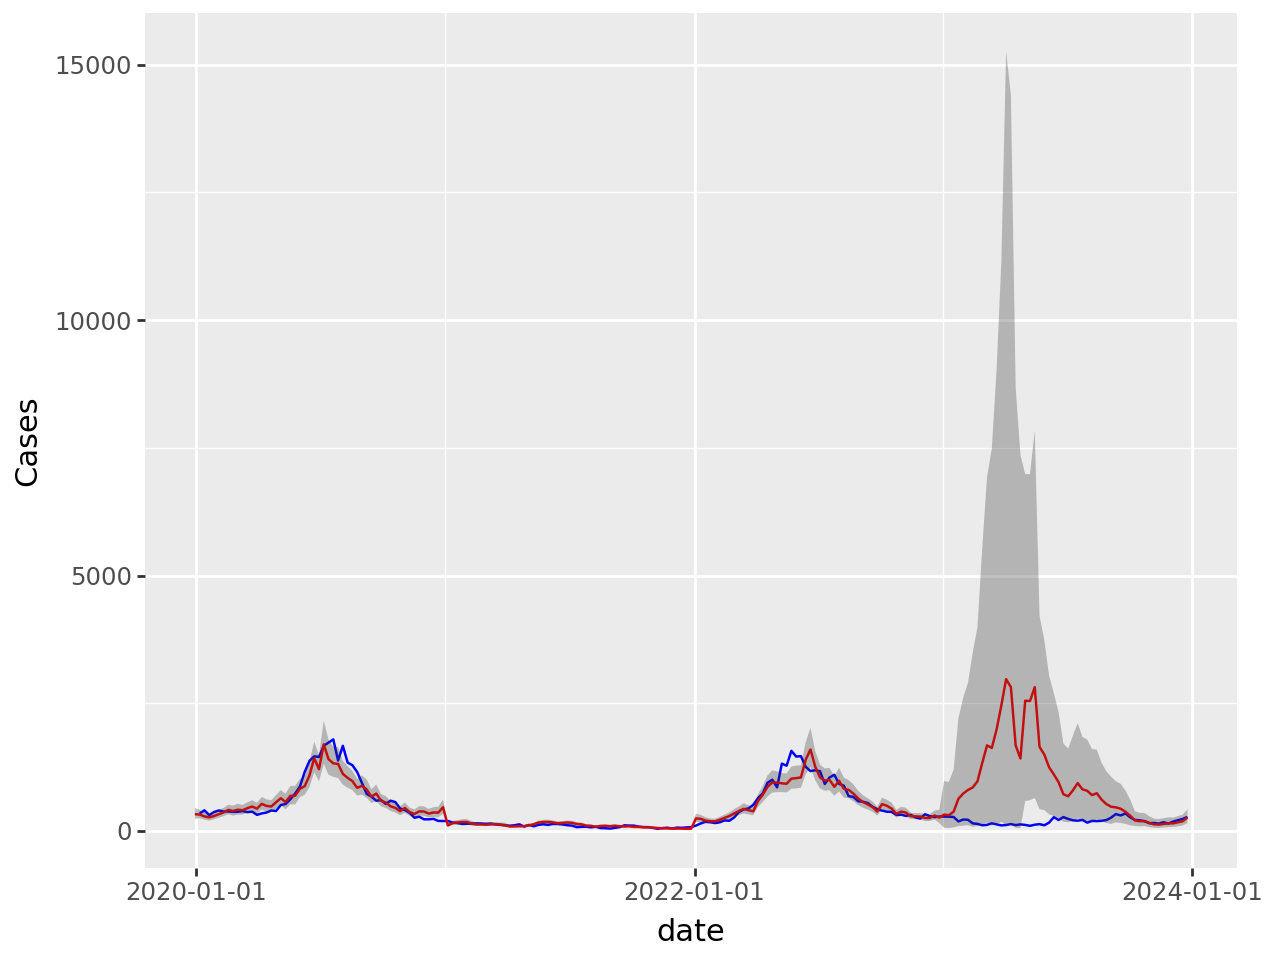

In [9]:
(
    ggplot()
    + geom_line(plot_df.query("cases == 'observed'"), aes("date", "mean"), color="blue")
    + geom_line(plot_df.query("cases == 'predicted'"), aes("date", "mean"), color="red")
    + geom_ribbon(plot_df.query("cases == 'predicted'"), aes(x="date", y="mean", ymin="lower", ymax="upper"), alpha=0.3)
    + ylab("Cases")
)